# Sentiment Analysis with Vader and Empath

In [5]:
import dask
import dask.dataframe as dd
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import csv
import json
from datetime import datetime
abs_path = '../../dataset' 

**NOTE**: Use this code once you have scraped all tweets from the given links!!!

In [ ]:
# Read CSVs and build up the dataframe for US_DATA
tweets_df1 = dd.read_csv(abs_path + '/jan_2021_US.csv',
                    # sep = '\t',  # Use with ES_data
                    usecols = ['tweet', 'language', 'date'], 
                    lineterminator = '\n')

tweets_df1=tweets_df1.loc[tweets_df1['lang']=='es'] # Exclude tweets not written in English #Use 'es' for ES_data 
tweets_df1=tweets_df1.loc[:, ['date', 'tweet']]

In [11]:
# Cleaning method
def tweetClean(tuit):
    tuit = str(tuit)
    tuit = re.sub('(www|https)[^\s]+', ' ', tuit)
    tuit = re.sub('#', ' ', tuit)
    tuit = re.sub('@', ' ', tuit)
    return tuit

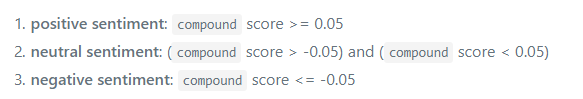

### Method definition: 
Clean for remove undesirables characters in text.  
Vader for sentiment analysis.  
Empath for topic categorization.  
GroupEmpath for grouping tweets by date.  

In [16]:
!pip install vaderSentiment empath

  Using cached empath-0.89.tar.gz (57 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for empath: filename=empath-0.89-py3-none-any.whl size=57821 sha256=d20f343b5ae09b06b2e1e6106147e6839ab9a718d44c661702cfdbd62011a413
  Stored in directory: /home/marcos.fernandez.pichel/.cache/pip/wheels/5b/58/77/7eed8eef4c6be0cca8920ac319d916811537a37407da220bf1
Successfully built empath
You should consider upgrading via the '/home/marcos.fernandez.pichel/anaconda3/bin/python -m pip install --upgrade pip' command.


In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
tweet="Thank you cmtrm for this lovely share"
score = analyzer.polarity_scores(tweet)
print(tweet)
print(score)
print("---------------------------------------")
tweet="MidgetTamer Another reason I hate that guy"
score = analyzer.polarity_scores(tweet)
print(tweet)
print(score)
print("---------------------------------------")
tweet="just gunna watch football tonight."
score = analyzer.polarity_scores(tweet)
print(tweet)
print(score)

Thank you cmtrm for this lovely share
{'neg': 0.0, 'neu': 0.303, 'pos': 0.697, 'compound': 0.8481}
---------------------------------------
MidgetTamer Another reason I hate that guy
{'neg': 0.381, 'neu': 0.619, 'pos': 0.0, 'compound': -0.5719}
---------------------------------------
just gunna watch football tonight.
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [18]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
from empath import Empath
lexicon = Empath()

def tweetClean(tuit):
    tuit = str(tuit)
    tuit = re.sub('(www|https)[^\s]+', ' ', tuit)
    tuit = re.sub('#', ' ', tuit)
    tuit = re.sub('@', ' ', tuit)
    return tuit

def getCompoundAnalysis(tweet):
    score = analyzer.polarity_scores(tweet)
    if(score['compound'] >= 0.05):
        return 'positive'
    elif(-0.05 < score['compound'] < 0.05):
        return 'neutral'
    elif(score['compound'] <= -0.05):
        return 'negative'
    
def getEmpathAnalysis(tweet):
    emp = lexicon.analyze(tweet, normalize=True)
    res = dict(filter(lambda x: x[1] > 0.0, emp.items()))
    return str(res)

def groupEmpath(col):
    return str(dict(pd.DataFrame(col.tolist()).fillna(0).mean()))

In [20]:
# Cleaning, getting sentiment from Vader, calculating weekdate
# Weekdate: First date of the week, used for group results by week.
tweets_df1['tweet'] = tweets_df1['tweet'].map(lambda x: tweetClean(x))
tweets_df1['sentiment'] = tweets_df1['tweet'].map(lambda x: getCompoundAnalysis(x))
tweets_df1['weekdate'] = dd.to_datetime(tweets_df1['date'],format='%Y-%m-%d') - dd.to_datetime(tweets_df1['date'],format='%Y-%m-%d').dt.weekday * np.timedelta64(1,'D')

In [ ]:
# Code block for computing and store in a separate file the Empath analysis for each tweet

output = (getEmpathAnalysis(tweet) for tweet in tweets_df1['tweet'])
print(datetime.now())   
countrow = 0
countiter = 1
with open(abs_path+'/'+'AnalysisEmpath.csv', "w") as csv_file:
    writer = csv.writer(csv_file, delimiter=',')
    for weekdate, empath in zip(tweets_df1.weekdate,output):
        writer.writerow([weekdate,empath])
        countrow += 1                 #
        if(countrow == 100000):       #  Code snippet for keeping track on progress
            print(100000 * countiter) #    Prints message on terminal with every 
            countiter += 1            #    100K tweets processed
            countrow = 0              #    
print(datetime.now()) 

2022-11-03 16:13:21.255276


In [5]:
tweets_df1=tweets_df1.compute() # Final compute. aprox 40 min for US data
tweets_df1['total'] = tweets_df1.groupby('weekdate')['tweet'].transform('count')

In [6]:
# Grouping by weekdate and storing in new CSV
tweets_grp = tweets_df1.groupby(['weekdate','sentiment','total']).size().reset_index(name='counts')
tweets_grp.to_csv('vader_grouped.csv',header=True, index=False)

In [ ]:
# Code block for grouping Empath data.
# Runned in separate runtime. Otherwise proccess crashes (using too much local resources)

def groupEmpath(col):
    return str(dict(pd.DataFrame(col.tolist()).fillna(0).mean()))

emp_df = pd.read_csv(abs_path+'/'+'AnalysisEmpath.csv',names=['weekdate','empadict'])
emp_df['empadict'] = emp_df['empadict'].map(lambda x: json.loads(re.sub('\'', '"', x)))
emp_grp = emp_df.groupby(['weekdate'])['empadict'].apply(groupEmpath).reset_index()

emp_grp.to_csv('emp_grouped.csv',header=True, index=False)

In [ ]:
# Code block for counting Empath data to determine which categories prevail over the others 
# Runned in separate runtime. Otherwise proccess crashes (using too much local resources)

def groupEmpathCounts(col):
    return str(dict(pd.DataFrame(col.tolist()).fillna(0).sum()))

emp_df = pd.read_csv(abs_path+'/'+'AnalysisEmpath.csv',names=['weekdate','empadict'])
emp_df['empadict'] = emp_df['empadict'].map(lambda x: re.sub('0\.[0-9]+', '1', x))
emp_df['empadict'] = emp_df['empadict'].map(lambda x: json.loads(re.sub('\'', '"', x)))
emp_grp = emp_df.groupby(['weekdate'])['empadict'].apply(groupEmpathCounts).reset_index()
emp_grp.to_csv('Results/emp_counts.csv',header=True, index=False)
